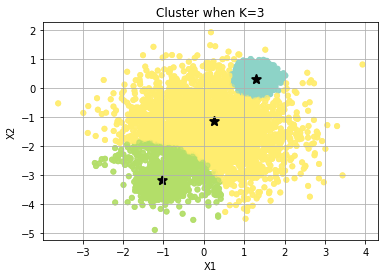

K = 3
Final loss: 20512.375


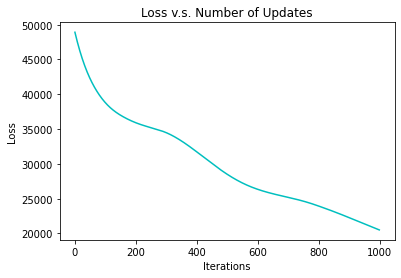

In [ ]:
import tensorflow as tf

# helper function from helper.py
def reduce_logsumexp(input_tensor, reduction_indices=1, keep_dims=False):
  """Computes the sum of elements across dimensions of a tensor in log domain.

     It uses a similar API to tf.reduce_sum.

  Args:
    input_tensor: The tensor to reduce. Should have numeric type.
    reduction_indices: The dimensions to reduce. 
    keep_dims: If true, retains reduced dimensions with length 1.
  Returns:
    The reduced tensor.
  """
  max_input_tensor1 = tf.reduce_max(
      input_tensor, reduction_indices, keep_dims=keep_dims)
  max_input_tensor2 = max_input_tensor1
  if not keep_dims:
    max_input_tensor2 = tf.expand_dims(max_input_tensor2, reduction_indices)
  return tf.log(
      tf.reduce_sum(
          tf.exp(input_tensor - max_input_tensor2),
          reduction_indices,
          keep_dims=keep_dims)) + max_input_tensor1

def logsoftmax(input_tensor):
  """Computes normal softmax nonlinearity in log domain.

     It can be used to normalize log probability.
     The softmax is always computed along the second dimension of the input Tensor.     

  Args:
    input_tensor: Unnormalized log probability.
  Returns:
    normalized log probability.
  """
  return input_tensor - reduce_logsumexp(input_tensor, reduction_indices=0, keep_dims=True)

# from part 1
import numpy as np
import matplotlib.pyplot as plt
import helper as hlp
import math

# Loading data
data = np.load('data2D.npy')
#data = np.load('data100D.npy')
[num_pts, dim] = np.shape(data)

# Distance function for GMM
def distanceFunc(X, MU):
    # Inputs
    # X: is an NxD matrix (N observations and D dimensions)
    # MU: is an KxD matrix (K means and D dimensions)

    # Outputs
    # pair_dist: is the pairwise distance matrix (NxK)

    newX = tf.expand_dims(X, 0)
    newMU = tf.expand_dims(MU, 1)
    dis = tf.reduce_sum(tf.square(tf.subtract(newX, newMU)), 2)
    output = tf.transpose(dis)
    return output

def log_GaussPDF(X, mu, sigma):
    # Inputs
    # X: N X D
    # mu: K X D
    # sigma: K X 1

    # Outputs:
    # log Gaussian PDF N X K

    StraightDist = distanceFunc(X, mu)
    Dist = -1* tf.div(StraightDist, tf.transpose(2*sigma))
    x = -1*tf.log((2*math.pi)**(dim/2)*sigma)
    return (tf.transpose(x)+ Dist)
  

def log_posterior(log_PDF, log_pi):
    # Input
    # log_PDF: log Gaussian PDF N X K
    # log_pi: K X 1

    # Outputs
    # log_post: N X K

    prob = tf.add(log_PDF, log_pi)
    sum = reduce_logsumexp(prob + log_pi , keep_dims = True)
    return prob - sum
    
# part 2.2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
import helper as hlp
from collections import Counter


def MoG(data, K, alpha, is_valid=False):
    # data: N x D
    N = data.shape[0]
    D = data.shape[1]

    if is_valid:
        valid_batch = int(N / 3.0)
        np.random.seed(45689)
        rnd_idx = np.arange(N)
        np.random.shuffle(rnd_idx)
        val_data = data[rnd_idx[:valid_batch]]
        data = data[rnd_idx[valid_batch:]]

    loss_list = []
    s = []
    valid_loss_list = []

    # initialize parameters
    iteration = 1000
    standard_deviation = 0.01

    X = tf.placeholder("float", [None, D], "X")
    mu = tf.Variable(tf.random_normal([K, D], stddev = standard_deviation)) 
    sigma = tf.Variable(tf.random_normal([K, 1], stddev = standard_deviation))
    exp_sigma = tf.exp(sigma)
    pi = tf.Variable(tf.random_normal([K, 1], stddev = standard_deviation))
    log_pi = tf.squeeze(logsoftmax(pi))

    # P(xn | zn = K)
    log_PDF = log_GaussPDF(X, mu, exp_sigma) 

    # reduce the total loss
    sum = reduce_logsumexp(log_PDF + log_pi, 1, keep_dims=True)
    loss = - tf.reduce_sum(sum)
    optimizer = tf.train.AdamOptimizer(learning_rate=alpha).minimize(loss)

    # determine clusters
    softmax = tf.nn.softmax(log_posterior(log_PDF, log_pi))
    pred = tf.argmax(softmax, 1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())

        for i in range(iteration):
            center, cur_l, _, s = sess.run([mu, loss, optimizer, pred], feed_dict={X:data})
            loss_list.append(cur_l)

            if is_valid:
                _, valid_loss, _, _ = sess.run([mu, loss, optimizer, pred], feed_dict={X: val_data})
                valid_loss_list.append(valid_loss)

        # plot cluster
        x_label = 'X1'
        y_label = 'X2'
        plotCluster(K,data,center,s,x_label,y_label)

    # plot loss
    x_label = 'Iterations'
    y_label = 'Loss'
    plotLoss(K, loss_list ,valid_loss_list, is_valid, x_label, y_label)

    # return valid_losses

def plotLoss(K, loss, valid_loss, is_valid, x_label, y_label):

  if is_valid is False:
    print("K = " + str(K))
    print("Final loss: " + str(loss[-1]))
    plt.title('Loss v.s. Number of Updates')
    losstype = "train_loss"
    plot_loss = loss

  else:
    print("K = " + str(K))
    print("Validation loss: " + str(valid_loss[-1]))
    plt.title('Validation Loss v.s. Number of Updates')
    losstype = "valid_loss"
    plot_loss = valid_loss
    
  plt.figure(1)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  N = len(plot_loss)
  plt.plot(range(N),plot_loss, c="c", label=losstype)
  plt.show()

def plotCluster(K, data, center, s, x_label, y_label):

  plt.title('Cluster when K=' + str(K))
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  for i in range(K):
    plt.scatter(data[:, 0], data[:, 1], c=s, cmap=plt.get_cmap('Set3'), s=25, alpha=0.6)
    
  plt.scatter(center[:, 0], center[:, 1], marker='*', c="black", cmap=plt.get_cmap('Set1'), s=80, linewidths=2)
  plt.grid()
  plt.show()



######### TESTING ##########
alpha = 0.005
data = np.load('data2D.npy')
# data = np.load('data100D.npy')
MoG(data,3,alpha)



In [ ]:
import tensorflow as tf

# helper function from helper.py
def reduce_logsumexp(input_tensor, reduction_indices=1, keep_dims=False):
  """Computes the sum of elements across dimensions of a tensor in log domain.

     It uses a similar API to tf.reduce_sum.

  Args:
    input_tensor: The tensor to reduce. Should have numeric type.
    reduction_indices: The dimensions to reduce. 
    keep_dims: If true, retains reduced dimensions with length 1.
  Returns:
    The reduced tensor.
  """
  max_input_tensor1 = tf.reduce_max(
      input_tensor, reduction_indices, keep_dims=keep_dims)
  max_input_tensor2 = max_input_tensor1
  if not keep_dims:
    max_input_tensor2 = tf.expand_dims(max_input_tensor2, reduction_indices)
  return tf.log(
      tf.reduce_sum(
          tf.exp(input_tensor - max_input_tensor2),
          reduction_indices,
          keep_dims=keep_dims)) + max_input_tensor1

def logsoftmax(input_tensor):
  """Computes normal softmax nonlinearity in log domain.

     It can be used to normalize log probability.
     The softmax is always computed along the second dimension of the input Tensor.     

  Args:
    input_tensor: Unnormalized log probability.
  Returns:
    normalized log probability.
  """
  return input_tensor - reduce_logsumexp(input_tensor, reduction_indices=0, keep_dims=True)

# from part 1
import numpy as np
import matplotlib.pyplot as plt
import helper as hlp
import math

# Loading data
data = np.load('/content/drive/My Drive/data2D.npy')
#data = np.load('data100D.npy')
[num_pts, dim] = np.shape(data)

# Distance function for GMM
def distanceFunc(X, MU):
    # Inputs
    # X: is an NxD matrix (N observations and D dimensions)
    # MU: is an KxD matrix (K means and D dimensions)

    # Outputs
    # pair_dist: is the pairwise distance matrix (NxK)

    newX = tf.expand_dims(X, 0)
    newMU = tf.expand_dims(MU, 1)
    dis = tf.reduce_sum(tf.square(tf.subtract(newX, newMU)), 2)
    output = tf.transpose(dis)
    return output

def log_GaussPDF(X, mu, sigma):
    # Inputs
    # X: N X D
    # mu: K X D
    # sigma: K X 1

    # Outputs:
    # log Gaussian PDF N X K

    StraightDist = distanceFunc(X, mu)
    Dist = -1* tf.div(StraightDist, tf.transpose(2*sigma))
    x = -1*tf.log((2*math.pi)**(dim/2)*sigma)
    return (tf.transpose(x)+ Dist)
  

def log_posterior(log_PDF, log_pi):
    # Input
    # log_PDF: log Gaussian PDF N X K
    # log_pi: K X 1

    # Outputs
    # log_post: N X K

    prob = tf.add(log_PDF, log_pi)
    sum = reduce_logsumexp(prob + log_pi , keep_dims = True)
    return prob - sum
    
# part 2.2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import numpy as np
import matplotlib.pyplot as plt
import helper as hlp
from collections import Counter


def MoG(data, K, alpha, is_valid=False):
    # data: N x D
    N = data.shape[0]
    D = data.shape[1]

    if is_valid:
        valid_batch = int(N / 3.0)
        np.random.seed(45689)
        rnd_idx = np.arange(N)
        np.random.shuffle(rnd_idx)
        val_data = data[rnd_idx[:valid_batch]]
        data = data[rnd_idx[valid_batch:]]

    losses = []
    assg = []
    valid_losses = []

    # initialize parameters
    iteration = 1000
    standard_deviation = 0.05

    X = tf.placeholder("float", [None, D], "X")
    mu = tf.Variable(tf.random_normal([K, D], stddev = standard_deviation)) 
    sigma = tf.Variable(tf.random_normal([K, 1], stddev = standard_deviation))
    exp_sigma = tf.exp(sigma)
    pi = tf.Variable(tf.random_normal([K, 1], stddev = standard_deviation))
    log_pi = tf.squeeze(logsoftmax(pi))

    # P(xn | zn = K)
    log_PDF = log_GaussPDF(X, mu, exp_sigma) 

    # reduce the total loss
    sum = reduce_logsumexp(log_PDF + log_pi, 1, keep_dims=True)
    loss = - tf.reduce_sum(sum)
    optimizer = tf.train.AdamOptimizer(learning_rate=alpha)
    train = optimizer.minimize(loss)

    # determine the clusters
    pred = tf.argmax(tf.nn.softmax(log_posterior(log_PDF, log_pi)), 1)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run(tf.local_variables_initializer())

        for i in range(iteration):
            center, cur_l, _, assg = sess.run([mu, loss, train, pred], feed_dict={X:data})
            losses.append(cur_l)

            if is_valid:
                _, valid_loss, _, _ = sess.run([mu, loss, train, pred], feed_dict={X: val_data})
                valid_losses.append(valid_loss)

        print("K = {}, Final loss: {}".format(K, losses[-1]))

        # plot cluster
        cluster = Counter(assg)
        for i in range(K):
          plt.scatter(data[:, 0], data[:, 1], c=assg, cmap=plt.get_cmap('Set3'), s=25, alpha=0.6)
          
        plt.scatter(center[:, 0], center[:, 1], marker='*', c="black", cmap=plt.get_cmap('Set1'), s=80, linewidths=2)
        plt.title('Cluster when K=' + str(K))
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.grid()
        plt.show()

    # if is_valid:
    #     print("K = {}, Validation loss: {}".format(K, valid_loss))

    plt.figure(1)
    plt.plot(range(len(losses)),losses,c="c", label="train_loss")
    # plt.plot(range(len(valid_losses)),valid_losses,c="r", label="valid_loss")
    plt.legend(loc = "best")
    plt.title('Loss v.s. Number of Updates')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()

    # return valid_losses
    

######### TESTING ##########
alpha = 0.005

data = np.load('/content/drive/My Drive/data2D.npy')

# data = np.load('data100D.npy')

MoG(data, 3, alpha, False)
# valid = []
# valid.append(MoG(data, 5, alpha, True))
# valid.append(MoG(data, 10, alpha, True))
# valid.append(MoG(data, 15, alpha, True))
# valid.append(MoG(data, 20, alpha, True))
# valid.append(MoG(data, 30, alpha, True))

# plt.figure(1)
# plt.plot(range(len(valid[0])),valid[0],c="r", label="K = 5")
# plt.plot(range(len(valid[1])),valid[1],c="g", label="K = 10")
# plt.plot(range(len(valid[2])),valid[2],c="b", label="K = 15")
# plt.plot(range(len(valid[3])),valid[3],c="m", label="K = 20")
# plt.plot(range(len(valid[4])),valid[4],c="y", label="K = 30")
# plt.legend(loc = "best")
# plt.title('Validation loss (MoG) with different K using data100D')
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.show()


FileNotFoundError: ignored

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
